# Spotify Hit Prediction (Simple Notebook)

本 Notebook 是为 Data Science 期末项目准备的简化版流程示例，包含：
1. 读取并初步了解数据
2. 简单数据清洗与新建二分类目标（Hit / Not Hit）
3. 使用 Decision Tree 和 Random Forest 训练模型并评估

> 注意：这里使用的是已经下载好的 `spotify-2023.csv` 文件。

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. 读取数据（路径根据你本机的位置修改，如果和本示例不同的话）
file_path = "spotify-2023.csv"  # 如果在同一文件夹下，保持这样即可

# 有些 CSV 会有编码问题，这里指定 encoding，并忽略坏字符
df = pd.read_csv(file_path, encoding="latin1")

# 查看前 5 行
df.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## 1. 基本数据探索 (EDA)
这里我们简单看看数据的整体结构，包括：
- 行列数
- 列名
- 数值列的统计信息

In [2]:

# 数据的行列数
print("Shape (rows, columns):", df.shape)

# 列名
print("\nColumns:\n", df.columns.tolist())

# 数值列的描述性统计
df.describe(include=[np.number]).T


Shape (rows, columns): (953, 24)

Columns:
 ['track_name', 'artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


,count,mean,std,min,25%,50%,75%,max
artist_count,953.0,1.556139,0.893044,1.0,1.0,1.0,2.0,8.0
released_year,953.0,2018.238195,11.116218,1930.0,2020.0,2022.0,2022.0,2023.0
released_month,953.0,6.033578,3.566435,1.0,3.0,6.0,9.0,12.0
released_day,953.0,13.930745,9.201949,1.0,6.0,13.0,22.0,31.0
in_spotify_playlists,953.0,5200.124869,7897.608990,31.0,875.0,2224.0,5542.0,52898.0
in_spotify_charts,953.0,12.009444,19.575992,0.0,0.0,3.0,16.0,147.0
in_apple_playlists,953.0,67.812172,86.441493,0.0,13.0,34.0,88.0,672.0
in_apple_charts,953.0,51.908709,50.630241,0.0,7.0,38.0,87.0,275.0
in_deezer_charts,953.0,2.666317,6.035599,0.0,0.0,0.0,2.0,58.0
bpm,953.0,122.540399,28.057802,65.0,100.0,121.0,140.0,206.0


## 2. 构造二分类目标：Hit vs Not Hit
在这个数据集中没有直接的 `popularity` 列，我们使用 `streams`（播放量）来定义 Hit：

- 计算 `streams` 的 75% 分位数（Q3）
- 如果某首歌的 `streams` ≥ Q3，则标记为 `Hit = 1`
- 否则为 `Hit = 0`


In [3]:

# 确保 streams 列为数值类型
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

# 去掉 streams 为空的行
df = df.dropna(subset=['streams'])

# 使用 streams 分位数定义 Hit
q3 = df['streams'].quantile(0.75)
print("75% quantile of streams:", q3)

df['hit'] = (df['streams'] >= q3).astype(int)

# 看看 0 和 1 的分布
df['hit'].value_counts()


75% quantile of streams: 673869022.0


hit
0    714
1    238
Name: count, dtype: int64

## 3. 简单可视化
我们画一个柱状图，看一下 Hit(1) 和 Not Hit(0) 的数量对比。

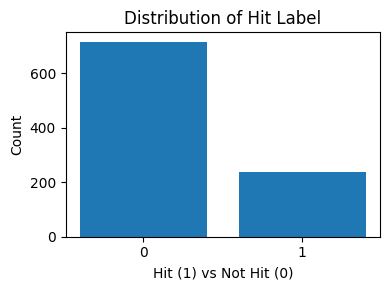

In [4]:

hit_counts = df['hit'].value_counts().sort_index()

plt.figure(figsize=(4, 3))
plt.bar(hit_counts.index.astype(str), hit_counts.values)
plt.xlabel('Hit (1) vs Not Hit (0)')
plt.ylabel('Count')
plt.title('Distribution of Hit Label')
plt.tight_layout()
plt.show()


### 3.1 额外可视化：`bpm` 的直方图
再画一个简单的直方图，看看歌曲节奏（bpm）的分布情况。

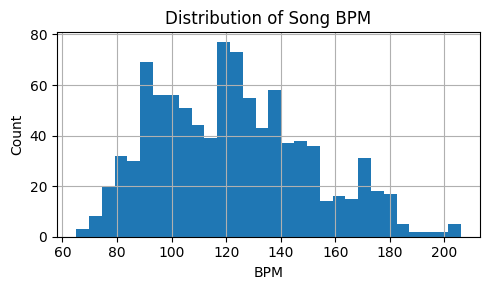

In [5]:

# 额外可视化：bpm 分布直方图
plt.figure(figsize=(5, 3))
df['bpm'].hist(bins=30)
plt.xlabel('BPM')
plt.ylabel('Count')
plt.title('Distribution of Song BPM')
plt.tight_layout()
plt.show()


## 4. 特征选择 (Features)
我们从数据中选取几个和歌曲特征相关的数值列作为特征：
- `bpm`
- `danceability_%`
- `valence_%`
- `energy_%`
- `acousticness_%`
- `instrumentalness_%`
- `liveness_%`
- `speechiness_%`

这些特征用于预测 `hit`。

In [6]:

feature_cols = [
    'bpm',
    'danceability_%',
    'valence_%',
    'energy_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

# 把这些列转换成数值类型（防止有脏数据）
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 丢弃在这些特征或 target 上有缺失值的行
model_df = df.dropna(subset=feature_cols + ['hit'])

X = model_df[feature_cols]
y = model_df['hit']

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())


X shape: (952, 8)
y distribution:
 hit
0    714
1    238
Name: count, dtype: int64


## 5. 划分训练集与测试集，并训练模型
我们会做：
1. 使用 `train_test_split` 划分训练集和测试集（80% / 20%）
2. 训练一个 `DecisionTreeClassifier`
3. 训练一个 `RandomForestClassifier`
4. 比较它们在测试集上的 Accuracy 和混淆矩阵


In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 761
Test size: 191


In [8]:

# ---- Decision Tree ----
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree Accuracy:", acc_dt)
print("Decision Tree Confusion Matrix:\n", cm_dt)
print("\nClassification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.6387434554973822
Decision Tree Confusion Matrix:
 [[107  36]
 [ 33  15]]

Classification Report (Decision Tree):

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       143
           1       0.29      0.31      0.30        48

    accuracy                           0.64       191
   macro avg       0.53      0.53      0.53       191
weighted avg       0.65      0.64      0.64       191



In [9]:

# ---- Random Forest ----
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Accuracy:", acc_rf)
print("Random Forest Confusion Matrix:\n", cm_rf)
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7696335078534031
Random Forest Confusion Matrix:
 [[139   4]
 [ 40   8]]

Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       143
           1       0.67      0.17      0.27        48

    accuracy                           0.77       191
   macro avg       0.72      0.57      0.57       191
weighted avg       0.75      0.77      0.71       191



In [10]:
import joblib

# 保存随机森林模型
joblib.dump(rf_clf, "../Model/best_model.pkl")


['../Model/best_model.pkl']

## 6. 模型错误类型简单解释（False Positives & False Negatives）

在上面的混淆矩阵中：
- **True Positive (TP)**：真实是 Hit(1)，模型也预测为 Hit(1)
- **True Negative (TN)**：真实是 Not Hit(0)，模型也预测为 Not Hit(0)
- **False Positive (FP)**：真实是 Not Hit(0)，但模型预测成 Hit(1)
- **False Negative (FN)**：真实是 Hit(1)，但模型预测成 Not Hit(0)

在本任务场景下可以这样理解：
- **FP（误判成 Hit 的歌）**：模型把一些其实播放量没那么高的歌，当成了热门歌曲。
- **FN（漏掉的 Hit 歌）**：模型把一些真实热门歌曲当成了普通歌。

通常来说：
- 如果你更关心“不要错过真正有潜力的热门歌”，就要尽量减少 **FN**。
- 如果你更关心“不要推荐太多其实不火的歌”，就要尽量减少 **FP**。

你可以在报告或 PPT 中，结合 Random Forest 的混淆矩阵，简单说明：
哪个错误（FP/FN）更多，以及这在业务上的含义。

## 7. 简单预测演示（Prediction Demo）
为了满足作业中 **PREDICT / Prediction Demo** 的要求，这里做一个非常简单的演示：

1. 取测试集中的前 10 条样本
2. 使用上面训练好的 **Random Forest 模型** 进行预测
3. 对比真实标签 (`y_true`) 和预测标签 (`y_pred`)


In [11]:

# 从测试集中取前 10 条样本
sample_X = X_test.head(10)
sample_y_true = y_test.head(10)

# 使用随机森林模型进行预测
sample_y_pred = rf_clf.predict(sample_X)

# 整理成一个小表格方便查看
demo_df = sample_X.copy()
demo_df['y_true'] = sample_y_true.values
demo_df['y_pred'] = sample_y_pred

demo_df


,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,y_true,y_pred
710,189,55,86,44,40,0,7,4,0,0
691,80,56,19,46,92,72,11,3,0,0
484,81,47,33,68,24,0,22,38,0,0
359,135,81,97,77,75,0,35,3,0,0
385,100,79,60,68,7,0,26,4,0,0
730,174,58,56,83,5,0,7,4,0,0
409,154,64,61,91,15,0,72,4,0,0
454,92,53,84,77,40,0,32,3,0,0
371,109,66,16,57,10,1,12,3,1,0
793,110,51,48,82,0,0,5,3,0,1


## 简单总结
- 本 Notebook 展示了一个从 **Spotify 歌曲数据 → 构造 Hit 标签 → 训练分类模型** 的完整流程。
- 你可以在此基础上：
  - 增加更多可视化（比如散点图、直方图、热力图）
  - 尝试更多特征工程
  - 调参（超参数搜索）
  - 保存你表现最好的模型，用于 Part 3 的预测演示。